In [1]:
## Set up and data

from matplotlib import pyplot
from scipy.misc import toimage
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Using TensorFlow backend.


In [3]:
## Create the model

n = 1
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128*n, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [4]:
## Compile the model

import keras

epochs = 100
opt = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [17]:
## Early stopping function

from keras.callbacks import Callback, EarlyStopping


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=[], verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()
        
        if len(self.value) < 4:
            print("Not enough epochs to evaluate early stopping")
            exit()
            
        if current >= np.min(self.value):
            print('Current not less than last 4, stopping.')
            self.model.stop_training = True
            
            
early_stop = EarlyStopping(monitor='acc', min_delta=0, patience=1, verbose=0, mode='auto')


In [6]:
## Train the model

model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=epochs, batch_size=64, verbose=1, callbacks = [early_stop])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 35s - loss: 1.6475 - acc: 0.4147 - val_loss: 2.2448 - val_acc: 0.3879
Epoch 2/100
50000/50000 [==============================] - 33s - loss: 1.2621 - acc: 0.5612 - val_loss: 1.8784 - val_acc: 0.4196
Epoch 3/100
50000/50000 [==============================] - 33s - loss: 1.0951 - acc: 0.6233 - val_loss: 3.3937 - val_acc: 0.2687
Epoch 4/100
50000/50000 [==============================] - 33s - loss: 0.9890 - acc: 0.6632 - val_loss: 1.1864 - val_acc: 0.6004
Epoch 5/100
50000/50000 [==============================] - 33s - loss: 0.9068 - acc: 0.6920 - val_loss: 1.1524 - val_acc: 0.6193
Epoch 6/100
50000/50000 [==============================] - 33s - loss: 0.8508 - acc: 0.7097 - val_loss: 1.2018 - val_acc: 0.6203
Epoch 7/100
50000/50000 [==============================] - 33s - loss: 0.8010 - acc: 0.7247 - val_loss: 1.1502 - val_acc: 0.6312
Epoch 8/100
50000/50000 [======================

In [7]:
## Save the model to disk

from keras.models import model_from_json
import os

# serialize model to JSON
model_json = model.to_json()
with open("model-n1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-n1.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
## POST TRAINING, RETRAIN LAST LAYERS

from matplotlib import pyplot as plt
from scipy.misc import toimage
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping

%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

        
# Function to show the weights of the metabolically regularized layer
def show_weights(model):
    for layer in model.layers:
        if layer.name == 'reg_layer-':
            w, b = layer.get_weights() # list of numpy arrays
            plt.imshow(w, interpolation='nearest')
            plt.title('dense layer weights')
            plt.show()
            

Using TensorFlow backend.


In [2]:
## Create regular and metabolic loss functions


from pdb import set_trace as t
import scipy

dry_l1 = 0
wet_l1 = 0.1
wet_lg = 0.1

def metabolic_loss_dry(weight_matrix):
    a = dry_l1 * l1_reg(weight_matrix)
    return a

def metabolic_loss_wet(weight_matrix):
    a = wet_l1 * l1_reg(weight_matrix) + wet_lg * lg_reg(weight_matrix,diag_decay)
    return a


def l1_reg(weight_matrix):
    return tf.reduce_sum(tf.abs(weight_matrix))


# builds a matrix of the same shape as the weight matrix, 
# but with big values around the diagonal and smaller or zeros off of it
# then substract it from the weight matrix and take the l1_reg of that
# this encourages the values to be near the diagonal
# which is forcing neurons to mostly pass on activations to close neurons
# on the next layer
def lg_reg(weight_matrix,diag_decay):
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    max_value = sess.run(tf.reduce_max(weight_matrix))
    
    row = [max_value/(i*diag_decay+1) for i in range(1024)]
    diagonalish = scipy.linalg.toeplitz(row)
    a = l1_reg(weight_matrix-diagonalish)
    return a


In [3]:
## Create two new networks from the trained model, the last two output layers are new and to be retrained 

from keras.models import model_from_json, Model
import os

# This model just has l1 regularization on the dense layer
def build_dry_model():
    json_file = open('model-n1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("model-n1.h5")
    # model with regular l1 regularization on a dense layer
    x = model.layers[-4].output
    x = Dense(1024, activation = 'relu', kernel_regularizer = metabolic_loss_dry, name = 'reg_layer')(x)
    x = Dropout(0.2, name = 'post-reg-drop')(x)
    predictions = Dense(num_classes, activation='softmax', name = 'final')(x)
    model_dry = Model(inputs = model.input, outputs = predictions)
    for layer in model_dry.layers[:-3]:
        layer.trainable = False
    return model_dry

# This model (wet for biological) has l1 and the metabolic regularization
def build_wet_model():
    json_file = open('model-n1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("model-n1.h5")
    # model with l1 and distance weight regularization on a dense layer
    y = model.layers[-4].output
    y = Dense(1024, activation = 'relu', kernel_regularizer = metabolic_loss_wet, name = 'reg_layer-')(y)
    y = Dropout(0.2, name = 'post-reg-drop-')(y)
    predictions = Dense(num_classes, activation='softmax', name = 'final-')(y)
    model_wet = Model(inputs = model.input, outputs = predictions)
    for layer in model_wet.layers[:-3]:
        layer.trainable = False
    return model_wet


Accuracy: 7.11%
Accuracy: 14.42%


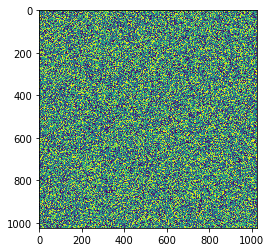

In [57]:
## Checking that the models don't work yet
early_stop = EarlyStopping(monitor='acc', min_delta=0, patience=2, verbose=0, mode='auto')

model_dry = build_dry_model()
model_dry.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_wet = build_wet_model()
model_wet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

scores = model_dry.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

scores = model_wet.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

show_weights(model_wet)

Result:
Clearly the models are not doing well yet, and the biological model has random weights

In [58]:
## Retraining the new models
model_dry.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=1, batch_size=64, verbose=1, callbacks = [early_stop])

model_wet.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=1, batch_size=64, verbose=1, callbacks = [])
    
## Final evaluation of the model
scores = model_dry.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model_wet.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 23s - loss: 0.3172 - acc: 0.9004 - val_loss: 0.7219 - val_acc: 0.8095
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 22s - loss: 964769.3562 - acc: 0.8050 - val_loss: 521852.0755 - val_acc: 0.7859
Accuracy: 80.95%
Accuracy: 78.59%


Result:
Now the model are performing around the same as the initial model

In [8]:
## Defining some useful callbacks

class MetricsHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
                
class WeightsHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.weights = []

    def on_batch_end(self, batch, logs={}):        
        for layer in self.model.layers:
            if layer.name == 'reg_layer-':
                w, b = layer.get_weights()
                self.weights.append(w)

In [17]:
## Showing learning and diagonalization of weights for metabolically regularized layer
wet_l1 = 0.1
wet_lg = 0.1
diag_decay = 0.5
def metabolic_loss_wet(weight_matrix):
    a = wet_l1 * l1_reg(weight_matrix) + wet_lg * lg_reg(weight_matrix,diag_decay)
    return a

model_wet = build_wet_model()
model_wet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = MetricsHistory()
weights_hist = WeightsHistory()
model_wet.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=1, batch_size=64, verbose=1, callbacks = [history, weights_hist])

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 17s - loss: 214.5926 - acc: 0.7999 - val_loss: 129.5711 - val_acc: 0.7570


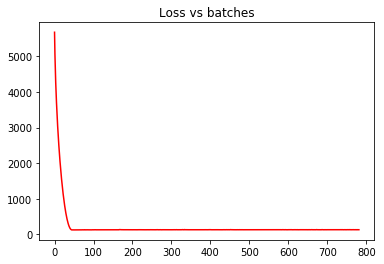

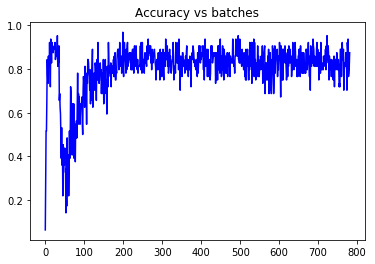

In [27]:
## Display loss and accuracy vs time

batches = range(len(history.losses))
plt.plot(history.losses,'r')
plt.title('Loss vs batches')
plt.show()
plt.plot(history.accuracies, 'b')
plt.title('Accuracy vs batches')
plt.show()

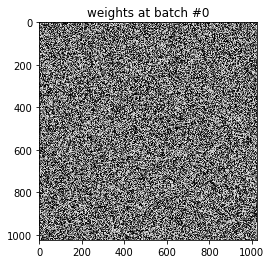

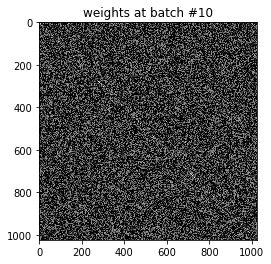

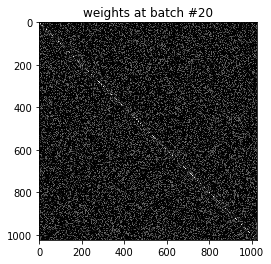

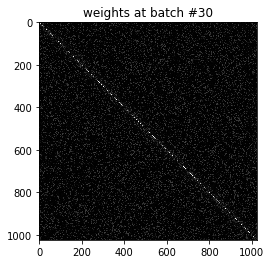

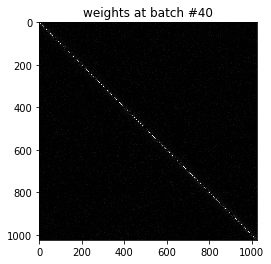

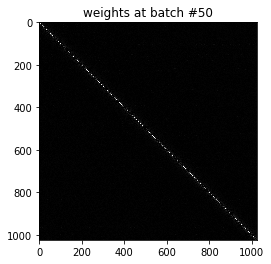

In [30]:
## Display a few weight matrices for the metabolic layer during learning

timepoints = [0,10,20,30,40,50]

for timepoint in timepoints:
    w = weights_hist.weights[timepoint]
    w = np.abs(w)
    plt.imshow(w, interpolation='nearest', cmap='gray')
    plt.title('weights at batch #'+str(timepoint))
    plt.show()

Result:
Clearly the metabolically regularized layer has weights that slowly converge towards the diagonal during learning. Meaning that the connections from the previous representation to the next are mostly in forward, not sideways, ie local.

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 4409.7004 - acc: 0.8934 - val_loss: 4364.5421 - val_acc: 0.8025


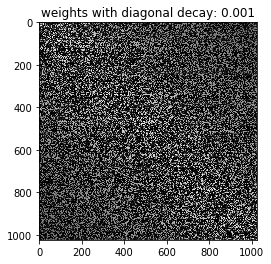

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 18s - loss: 1897.2311 - acc: 0.8924 - val_loss: 1836.3593 - val_acc: 0.8099


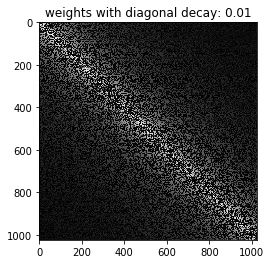

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 494.1764 - acc: 0.8817 - val_loss: 412.2411 - val_acc: 0.8106


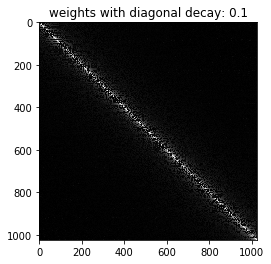

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 245.2079 - acc: 0.8269 - val_loss: 158.6801 - val_acc: 0.7427


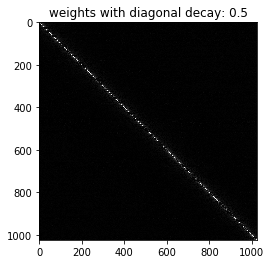

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 16s - loss: 214.9707 - acc: 0.7950 - val_loss: 128.0215 - val_acc: 0.7672


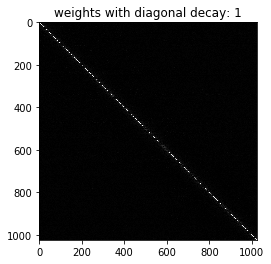

In [33]:
## Diagonalization vs regularizing matrix shape
# Here I am varying the extent to which the matrix in the regularization is diagonal dominant
# The distance between this matrix and the weight matrix is then added to the loss

wet_l1 = 0.1
wet_lg = 0.1
diag_decays= [0.001, 0.01, 0.1, 0.5, 1]

for diag_decay in diag_decays:
    def metabolic_loss_wet(weight_matrix):
        a = wet_l1 * l1_reg(weight_matrix) + wet_lg * lg_reg(weight_matrix,diag_decay)
        return a

    model_wet = build_wet_model()
    model_wet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = MetricsHistory()
    weights_hist = WeightsHistory()
    model_wet.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=1, batch_size=64, verbose=1, callbacks = [history,weights_hist])
    
    w = weights_hist.weights[-1]
    w = np.abs(w)
    plt.imshow(w, interpolation='nearest', cmap='gray')
    plt.title('weights with diagonal decay: '+str(diag_decay))
    plt.show()



Result:
Here we see that by varying the extent to which the regularizing matrix has big values on the diagonal directly influences the weights of the regularized layer. In effect the regularizing matrix acts as a template for the weights. 

In [51]:
## Testing the initial loss & final accuracy vs the weight of the metabolic regularization

reg_factors = [0.01, 0.1, 1, 10, 100, 1000]
num_repeats = 4

final_accuracies = []
initial_losses = []

for reg_factor in reg_factors:
    a = []
    l = []
    for i in range(num_repeats):
        
        def metabolic_loss_wet(weight_matrix):
            a = wet_l1 * l1_reg(weight_matrix) + reg_factor * lg_reg(weight_matrix,diag_decay)
            return a

        model_wet = build_wet_model()
        model_wet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        history = MetricsHistory()

        model_wet.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=1, batch_size=64, verbose=1, callbacks = [history])
        
        a.append(history.accuracies[-1])
        l.append(history.losses[0])
        
    final_accuracies.append(a)
    initial_losses.append(l)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 20s - loss: 111.6281 - acc: 0.6749 - val_loss: 63.8502 - val_acc: 0.4712
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 21s - loss: 111.6003 - acc: 0.6778 - val_loss: 63.6750 - val_acc: 0.5603
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 21s - loss: 111.6535 - acc: 0.6759 - val_loss: 64.3001 - val_acc: 0.3040
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 20s - loss: 111.6052 - acc: 0.6813 - val_loss: 63.5831 - val_acc: 0.5253
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 22s - loss: 214.5005 - acc: 0.8024 - val_loss: 129.2577 - val_acc: 0.6958
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==========================

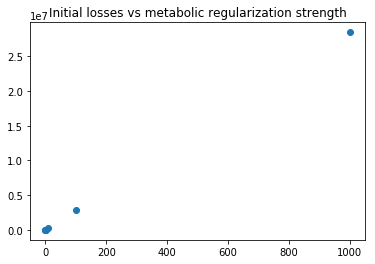

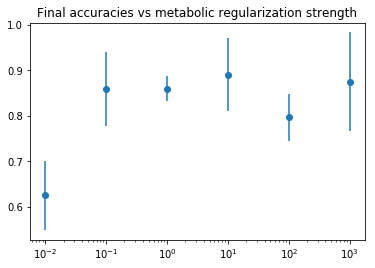

In [60]:
l = np.asmatrix(initial_losses)
a = np.asmatrix(final_accuracies)

a_errors = [np.std(i) for i in a]
l_errors = [np.std(i) for i in l]

plt.errorbar(reg_factors, np.mean(l,axis=1), yerr=l_errors, fmt='o')
plt.title('Initial losses vs metabolic regularization strength')

plt.show()

plt.errorbar(reg_factors, np.mean(a,axis=1), yerr=a_errors, fmt='o')
plt.title('Final accuracies vs metabolic regularization strength')
ax = plt.gca()
ax.set_xscale('log')
plt.show()

Result:
We see that by varying the weight of regularizing to incentivize local connections, the initial loss varies directly with the weight, which is to be expected. We also see that the final accuracy does not really depend on the how strongly we are constraining the layer to be biological. The low value for the first weight is due to a lower loss and thus a lower pressure to optimize the weights ie to learn in general, but would reach the other levels given more time to train.
Thus this biological constraint does not have an effect on performance.

In [34]:
## Build a biological model

wet_l1 = 0.1
wet_lg = 10
diag_decay = 0.5

def metabolic_loss_wet(weight_matrix):
    a = wet_l1 * l1_reg(weight_matrix) + wet_lg * lg_reg(weight_matrix,diag_decay)
    return a

model_wet = build_wet_model()
model_wet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = MetricsHistory()

model_wet.fit(X_train, y_train, validation_data=(X_test, y_test), 
      epochs=1, batch_size=64, verbose=1, callbacks = [history])


Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 14s - loss: 9841.3046 - acc: 0.8304 - val_loss: 5359.8926 - val_acc: 0.7906


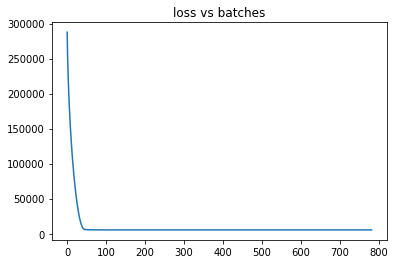

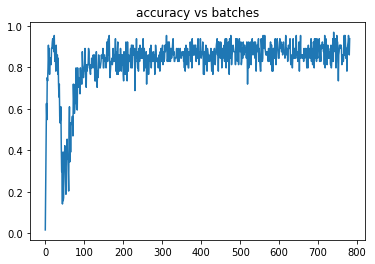

In [35]:
## Check that it's working

plt.plot(history.losses)
plt.title('loss vs batches')
plt.show()

plt.plot(history.accuracies)
plt.title('accuracy vs batches')
plt.show()

In [36]:
## Build partial copy of model to access regularized layer representation

intermediate_layer_model = Model(inputs=model_wet.input,
                                 outputs=model_wet.get_layer('reg_layer-').output)
intermediate_layer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


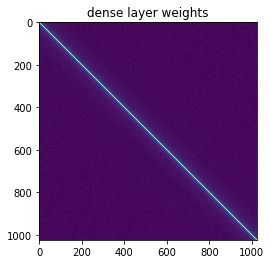

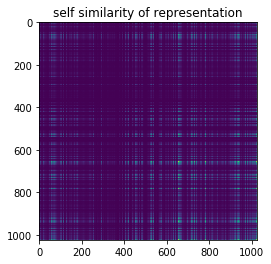

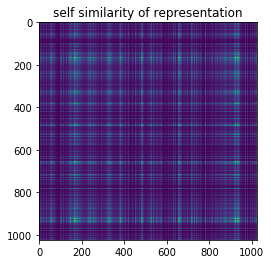

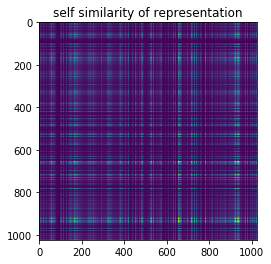

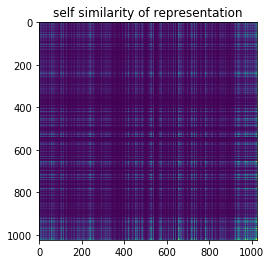

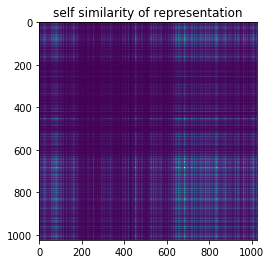

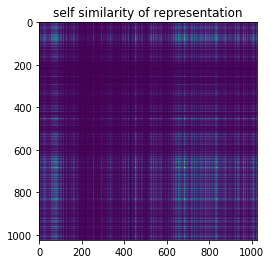

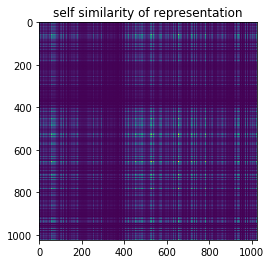

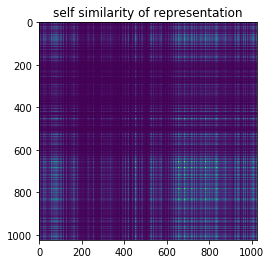

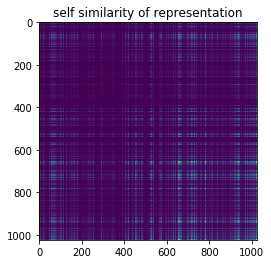

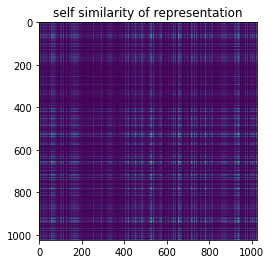

In [37]:
show_weights(model_wet)

for i in range(10):
    x = X_test[i,:,:]
    x = np.expand_dims(x, axis=0)

    rep = intermediate_layer_model.predict(x)
    cross = rep.T.dot(rep)
    plt.figure()
    plt.imshow(cross)
    plt.title('self similarity of representation')
    plt.plot()

Result:
The self similarity of the representation does not have a diagonal dominance. This means that the activation of a neuron after the biological connection is not more similar to its neihbors than further neurons. Thus there doesn't seem to be functional localization. The lines in the plot simply show activations near zero.

Conclusion:
My project consisted in attempting to see functional specificity arise out of a biological loss. This loss forced a near final dense layer to project mostly forward instead of to all units in the next layer. 

I built a neural network to classify images. I then removed the last few layers and retrained it with this biological loss, and again without it.

First the two new models performed the same. The biological model did have weights mostly distributed on its diagonal, indicating that the activation were mostly transfered forward not sideways. Additionally I showed that this loss does not cause a decrease in performance. The final accuracy of the model is independent on how much the model is forced to project forward only.

The biological model did not display function localization however. The representations after the biological layer are not clustered. That is to say, it is not more likely for a neuron to have a similar activation as another just because they are closer. 

Future directions:
Repeating this process with multiple biological layers might cause the functional localization to arise. Indeed it may be that the biological layer is simply passing the last layers activation forward without extra transformation.

